# Self-Supervised Learning Using Projection Heads

In [1]:
"""
Self-Supervised Learning (SSL) aims to produce useful feature representations without access to 
any human-labeled data annotations. -- K Gupta Et al.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
import sys

!{sys.executable} -m pip install nbimporter

import nbimporter
import my_progressbar as pb

Length of the training set: 60000
Length of the test set: 10000
The number 5:


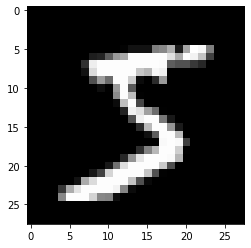

The number 0:


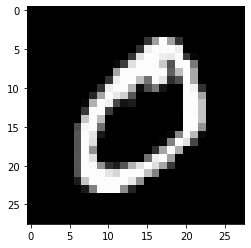

The number 4:


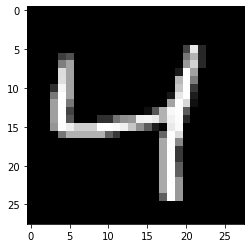

In [3]:
# downloading and rendering sample MNIST data

import torchvision
import torchvision.datasets as datasets

device= 'cuda' if torch.cuda.is_available() else 'cpu'

# downloading MNIST
mnist_trainset= datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# printing lengths 
print('Length of the training set: {}'.format(len(mnist_trainset)))
print('Length of the test set: {}'.format(len(mnist_testset)))

# rendering some examples
for i in range(3):
    print('The number {}:'.format(mnist_trainset[i][1]))
    plt.imshow(mnist_trainset[i][0], cmap= 'gray')
    plt.show()

In [16]:
"""
We will discard all but 200 of the training labels. That means we will have a set of 200 labeled images 
to train from, and 59,800 unlabeled images to train from. This modification reflects the types of 
applications in which self supervision is most useful: Datasets with a lot of data, but which are expensive 
to label.
"""

# creating unlabeled data, and handling necessary data preprocessing

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

# data extraction
# unlabeling some data, and one-hot encoding the labels which remain

partition_index= 200

def one_hot(y):
    # for covering a np array of 0-9 into a one-hot encoding of vectors of length 10
    b= np.zeros((y.size, y.max()+1))
    b[np.arange(y.size), y]= 1
    
    return b

print('Processing labeld training x and y')
train_x= np.asarray([np.asarray(mnist_trainset[i][0]) for i in tqdm(range(partition_index))])
train_y= one_hot(np.asarray([np.asarray(mnist_trainset[i][1]) for i in tqdm(range(partition_index))]))

print('Processing unlabeled training data')
train_unlabeled= np.asarray([np.asarray(mnist_trainset[i][0]) for i in tqdm(range(partition_index, 
                                                                                  len(mnist_trainset)))])

print('Processing labeled test x and y')
test_x= np.asarray([np.asarray(mnist_testset[i][0]) for i in tqdm(range(len(mnist_testset)))])
test_y= one_hot(np.asarray([np.asarray(mnist_testset[i][1]) for i in tqdm(range(len(mnist_testset)))]))


# data reformating
# adding a channel dimension and covering to pytorch

# adding a dimension to all X values to put them in the proper shape
# (batch_size, channels, x, y)
print('Reformatting shape...')
train_x= np.expand_dims(train_x, 1)
train_unlabeled= np.expand_dims(train_unlabeled, 1)
test_x= np.expand_dims(test_x, 1)

# converting data to pytorch type
torch_train_x= torch.tensor(train_x.astype(np.float32), requires_grad=True).to(device)
torch_train_y= torch.tensor(train_y).to(device)
torch_train_unlabeled= torch.tensor(train_unlabeled.astype(np.float32), requires_grad=True).to(device)
torch_test_x= torch.tensor(test_x.astype(np.float32), requires_grad=True).to(device)
torch_test_y= torch.tensor(test_y).to(device)

print('Done.')

Processing labeld training x and y


100%|██████████| 200/200 [00:00<00:00, 21616.78it/s]


Processing unlabeled training data


100%|██████████| 59800/59800 [00:03<00:00, 16217.67it/s]


Processing labeled test x and y


100%|██████████| 10000/10000 [00:00<00:00, 27365.17it/s]


Reformatting shape...
Done.


In [17]:
"""
Using PyTorch to create a modified, smaller version of AlexNet

To speed up training, this problem uses a super simple conv net and minimal hyperparameter exploration. 
This model has two general parts: the convolutional backbone and the densely connected head.
"""

import torch.nn.functional as F

# defining model backbone
class Backbone(nn.Module):
    
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1= nn.Conv2d(1, 16, 3)
        self.conv2= nn.Conv2d(16, 16, 3)
        self.conv3= nn.Conv2d(16, 32, 3)
        
        if torch.cuda.is_available():
            self.cuda()
            
    def forward(self, x):
        x= F.relu(self.conv1(x))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.conv2(x))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.conv3(x))
        x= F.max_pool2d(x, 2)
        
        x= torch.flatten(x, 1)
        
        return x

    
# defining model head
class Head(nn.Module):
    
    def __init__(self, n_class=10):
        super(Head, self).__init__()
        self.fc1= nn.Linear(32, 32)
        self.fc2= nn.Linear(32, 16)
        self.fc3= nn.Linear(16, n_class)
        
        if torch.cuda.is_available():
            self.cuda()
            
    def forward(self, x):
        x= self.fc1(x)
        x= F.relu(x)
        x= self.fc2(x)
        x= F.relu(x)
        x= self.fc3(x)
        x= F.softmax(x, 1)
        
        return x
    
    
# defining the full model
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.backbone= Backbone()
        self.head= Head()
        
        if torch.cuda.is_available():
            self.cuda()
            
    def forward(self, x):
        x= self.backbone(x)
        x= self.head(x)
        
        return x
    

model_baseline= Model()
print(model_baseline(torch_train_x[:1]).shape)
model_baseline

torch.Size([1, 10])


Model(
  (backbone): Backbone(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Head(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [18]:
total_params= sum(p.numel() for p in model_baseline.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 8874


Progress: [█████████...............................] 23.9% - Est wait 121:31.6 min   
Early stopping at epoch 2389


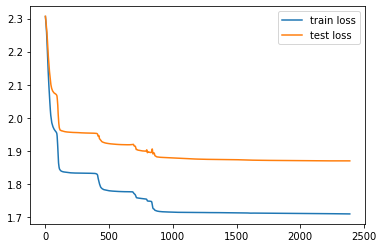

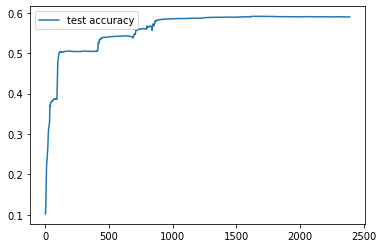

max accuracy: 0.5916


In [14]:
"""
Training model using only supervised learning, and rendering the results.
To get an idea of how much self supervision improves performance, we'll train 
our baseline model on only the 200 labeled samples.
This supervised training function is reused in the future for fine tuning
"""

def supervised_train(model, early_stop:bool=False, cutoff=1e-9):
    
    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    batch_size= 64
    lr= 0.001
    momentum= 0.9
    num_epochs= 10000
    epoch_size= int(len(train_x)/batch_size)-1
    
    # defining a SGD optimizer
    optimizer= torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    # defining the loss function
    loss_fn= torch.nn.CrossEntropyLoss()
    
    train_hist= []
    test_hist= []
    test_accuracy= []
    
    # for early stopping
    cutoff_ratio= cutoff
    patience= 10
    patience_count= 0
    previous_loss= 1e10
    
    
    #for epoch in tqdm(range(num_epochs)):
    for epoch in pb.progressbar(range(num_epochs), "Progress: "):
        
        # iterating over all batches
        for i in range(epoch_size):
            
            # put the model in training mode, so that things like dropout work
            model.train(True)
            
            # zero gradients
            optimizer.zero_grad()
            
            # extracting X and y values from batch
            X= torch_train_x[(i * batch_size):((i+1) * batch_size)]
            y= torch_train_y[(i * batch_size):((i+1) * batch_size)]
            
            # make predictions for this batch
            y_pred= model(X)
            
            # compute gradients
            loss= loss_fn(y_pred, y)
            loss.backward()
            
            # adjust learning weights
            optimizer.step()
            
        
        with torch.no_grad():
            
            # disable things like dropout, if they exist
            model.train(False)
            
            # calculating epoch training and test loss
            train_loss= loss_fn(model(torch_train_x), torch_train_y).cpu().numpy()
            y_pred_test= model(torch_test_x)
            test_loss= loss_fn(y_pred_test, torch_test_y).cpu().numpy()
            
            train_hist.append(train_loss)
            test_hist.append(test_loss)
            
            # computing test accuracy
            matches= np.equal(np.argmax(y_pred_test.cpu().numpy(), axis=1), 
                              np.argmax(torch_test_y.cpu().numpy(), axis=1))
            test_accuracy.append(matches.sum() / len(matches))
        
        
        # for early stopping -- calculating loss change
        loss_change= np.abs(previous_loss - train_loss)
        
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change < cutoff_ratio):
            patience_count += 1
            
            if (patience_count > patience):
                print('\nEarly stopping at epoch {}'.format(epoch))
                break
        else:
            patience_count= 0

        # setting current train loss as previous loss
        previous_loss= train_loss
        
    
    # ploting
    plt.plot(train_hist, label='train loss')
    plt.plot(test_hist, label='test loss')
    plt.legend()
    plt.show()
    
    plt.plot(test_accuracy, label='test accuracy')
    plt.legend()
    plt.show()
    
    maxacc= max(test_accuracy)
    print('max accuracy: {}'.format(maxacc))
    
    return maxacc


supervised_maxacc= supervised_train(model_baseline, early_stop=True, cutoff=1e-6)

Progress: [████████████████████████████████████████] 100.0% - Elapsed time 171:07 min   



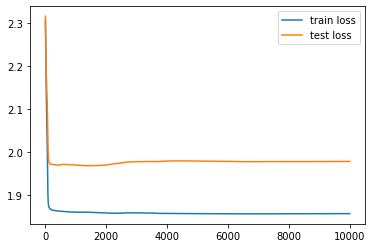

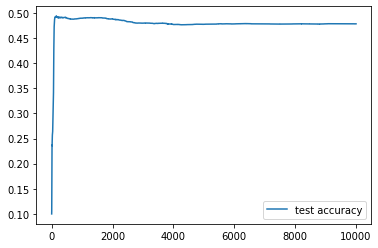

max accuracy: 0.4936


In [15]:
model_baseline_2= Model()

supervised_maxacc= supervised_train(model_baseline_2)

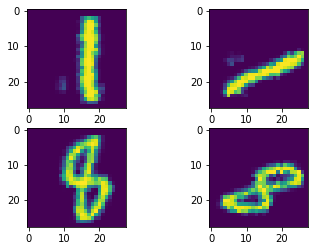

In [7]:
import torchvision.transforms as T

class Augment:
    """
    A stochastic data augmentation module transforms any given data example randomly resulting in two 
    correlated views of the same example, denoted x'i and x'j, which we consider as a positive pair.
    """
    
    def __init__(self):
        
        blur= T.GaussianBlur((3, 3), (0.1, 2.0))
        
        self.train_transform= torch.nn.Sequential(
            T.RandomAffine(degrees= (-50, 50), translate= (0.1, 0.1), scale=(0.5, 1.5), shear=0.2),
            T.RandomPerspective(0.4, 0.5),
            T.RandomPerspective(0.2, 0.5),
            T.RandomPerspective(0.2, 0.5),
            T.RandomApply([blur], p=0.25),
            T.RandomApply([blur], p=0.25)
        )
        
    def __call__(self, x):
        
        return self.train_transform(x), self.train_transform(x)
    
    
# generating test augmentation
a= Augment()
aug= a(torch_train_unlabeled[0:100])

i= 1
f, axarr= plt.subplots(2, 2)

# positive pair
axarr[0, 0].imshow(aug[0].cpu().detach().numpy()[i,0])
axarr[0, 1].imshow(aug[1].cpu().detach().numpy()[i,0])

# another positive pair
axarr[1, 0].imshow(aug[0].cpu().detach().numpy()[i+1,0])
axarr[1, 1].imshow(aug[1].cpu().detach().numpy()[i+1,0])
plt.show()

In [8]:
"""
Contrastive loss is the loss function used to entice positive pairs to be positioned closely in an 
embedding space, and negative pairs to be positioned further apart.
"""

class ContrastiveLoss(nn.Module):
    
    # Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    def __init__(self, batch_size, temperature=0.5):
        """
        Defining certain constants used between calculations. The mask is important
        in understanding which are positive and negative examples. For more information see
        https://theaisummer.com/simclr/
        """
        super().__init__()
        self.batch_size= batch_size
        self.temperature= temperature
        self.mask= (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)
        
    
    def calc_similarity_batch(self, a, b):
        """
        Defines the cosin similarity between one example, and all other examples.
        For more information see https://theaisummer.com/simclr/
        """
        representations= torch.cat([a, b], dim=0)
        
        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
    
    
    def forward(self, proj_1, proj_2):
        """
        The actual loss function, where proj_1 and proj_2 are embeddings from the projection head. 
        This function calculates the cosin similarity between all vectors, and rewards closeness 
        between examples which come from the same example, and farness for examples which do not. 
        For more information see https://theaisummer.com/simclr/
        """
        batch_size= proj_1.shape[0]
        z_i= F.normalize(proj_1, p=2, dim=1)
        z_j= F.normalize(proj_2, p=2, dim=1)

        similarity_matrix= self.calc_similarity_batch(z_i, z_j)

        sim_ij= torch.diag(similarity_matrix, batch_size)
        sim_ji= torch.diag(similarity_matrix, -batch_size)

        positives= torch.cat([sim_ij, sim_ji], dim=0)

        nominator= torch.exp(positives / self.temperature)

        denominator= self.mask * torch.exp(similarity_matrix / self.temperature)

        all_losses= -torch.log(nominator / torch.sum(denominator, dim=1))
        loss= torch.sum(all_losses) / (2 * self.batch_size)
        
        return loss
    
    
# testing
loss= ContrastiveLoss(torch_train_x.shape[0]).forward
fake_proj_0, fake_proj_1= a(torch_train_x)
fake_proj_0= fake_proj_0[:,0,:,0]
fake_proj_1= fake_proj_1[:,0,:,0]

loss(fake_proj_0, fake_proj_1)

tensor(5.9890, grad_fn=<DivBackward0>)

In [11]:
"""
Self Supervised Training
Training the model to understand image similarity and difference via self supervision and contrastive loss. 
Because this is an intermediary step, it's difficult to create clear and intuitive performance indicators.
"""

from torch.optim.lr_scheduler import ExponentialLR

def self_supervised_train(model, early_stop:bool=False, cutoff=0.001):

    # defining key hyperparameters explicitly (instead of hyperparamater search)
    batch_size= 512
    lr=1e-3
    num_epochs= 100
    epoch_size= round(torch_train_unlabeled.shape[0]/batch_size)-1

    # defining key learning functions 
    optimizer= torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn= ContrastiveLoss(batch_size).forward
    augment_fn= Augment()

    # for exponentially decreasing learning rate
    scheduler= ExponentialLR(optimizer, gamma=0.95)


    # for book keeping
    loss_hist= []
    improvement_hist= []
    schedule_hist= []

    # for early stopping
    cutoff_ratio= cutoff
    patience= 5
    patience_count= 0
    avg_loss= 1e10
    

    # training loop
    for i in range(num_epochs):

        print('Epoch {}/{}'.format(i, num_epochs))

        total_loss= 0
        loss_change= 0

        #for j in tqdm(range(epoch_size)):
        for j in pb.progressbar(range(epoch_size), "Progress: "):

            # getting random batch
            X= torch_train_unlabeled[(j * batch_size):((j+1) * batch_size)]

            # creating pairs of augmented batches
            X_aug_i, X_aug_j= augment_fn(X)

            # ensuring gradients are zero
            optimizer.zero_grad()

            # passing through the model
            z_i= model(X_aug_i)
            z_j= model(X_aug_j)

            # calculating loss on the model embeddings, and computing gradients
            loss= loss_fn(z_i, z_j)
            loss.backward()

            # adjust learning weights
            optimizer.step()

            
            # checking if backpropagation resulted in a reduction of the loss
            if True:
                # passing through the model, now that parameters have been updated
                z_i= model(X_aug_i)
                z_j= model(X_aug_j)

                # calculating new loss value
                new_loss= loss_fn(z_i, z_j)

                loss_change += (new_loss.cpu().detach().numpy() - loss.cpu().detach().numpy())

            total_loss += loss.cpu().detach().numpy()

            # step learning rate scheduler
            schedule_hist.append(scheduler.get_last_lr())

        scheduler.step()


        # for early stopping -- calculating percentage loss reduction
        new_avg_loss= total_loss/epoch_size
        per_loss_reduction= (avg_loss - new_avg_loss)/avg_loss
        print('Percentage Loss Reduction: {}'.format(per_loss_reduction))

        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and per_loss_reduction < cutoff_ratio):
            patience_count += 1
            print('Patience counter: {}'.format(patience_count))

            if (patience_count > patience):
                print('Early stopping.')
                break
        else:
            patience_count= 0

        # setting new loss as previous loss 
        avg_loss= new_avg_loss


        # book keeping
        avg_improvement= loss_change/epoch_size
        loss_hist.append(avg_loss)
        improvement_hist.append(avg_improvement)

        print('Average Loss: {}'.format(avg_loss))
        print('Average Loss change (if calculated): {}'.format(avg_improvement))
        
    return schedule_hist, loss_hist, improvement_hist


# defining a new model
model= Model()
model.train()

schedule_hist,loss_hist,improvement_hist= self_supervised_train(model, early_stop=True)

Epoch 0/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:14 min   

Percentage Loss Reduction: 0.9999999993083256
Average Loss: 6.9167443226123675
Average Loss change (if calculated): -0.012063659470656822
Epoch 1/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:11 min   

Percentage Loss Reduction: 0.01708598580038306
Average Loss: 6.798564927331332
Average Loss change (if calculated): -0.017126128591340165
Epoch 2/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:11 min   

Percentage Loss Reduction: 0.031787189831070574
Average Loss: 6.582457653407393
Average Loss change (if calculated): -0.023627564824860673
Epoch 3/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:12 min   

Percentage Loss Reduction: 0.019786598733340783
Average Loss: 6.452213205140213
Average Loss change (if calculated): -0.02406615635444378
Epoch 4/100
Progress: [████████████████████

Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:03 min   

Percentage Loss Reduction: 0.00038010586858230433
Patience counter: 1
Average Loss: 6.021488350013207
Average Loss change (if calculated): -0.0035582739731361127
Epoch 34/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:03 min   

Percentage Loss Reduction: -0.00011827802247962336
Patience counter: 2
Average Loss: 6.02220055974763
Average Loss change (if calculated): -0.0036272632664647595
Epoch 35/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:00 min   

Percentage Loss Reduction: -0.0005356335039462802
Patience counter: 3
Average Loss: 6.025426252134915
Average Loss change (if calculated): -0.003760317276264059
Epoch 36/100
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 02:01 min   

Percentage Loss Reduction: 0.0012971652435855806
Average Loss: 6.017610278622858
Average Loss change (if calculated): -0

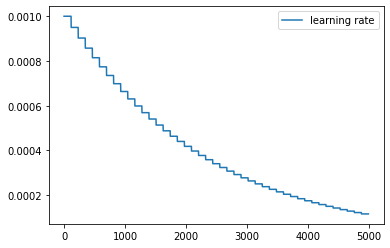

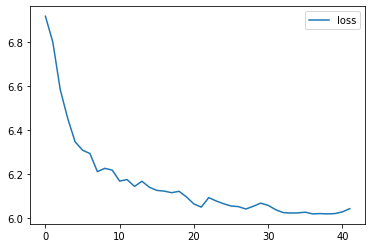

In [12]:
# Self Supervised Training Progress

plt.plot(schedule_hist, label='learning rate')
plt.legend()
plt.show()

plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

Training results with the original head
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 159:07 min   



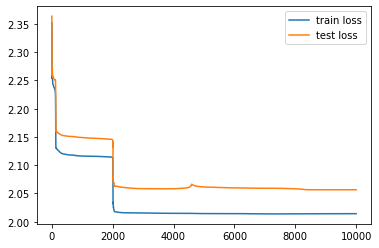

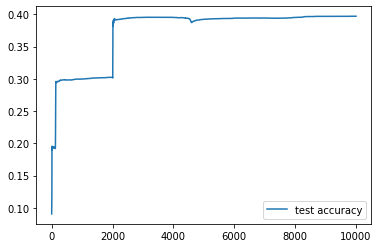

max accuracy: 0.3969


Training results with randomly initialized head
Progress: [████████████████████████████████████████] 100.0% - Elapsed time 161:14 min   



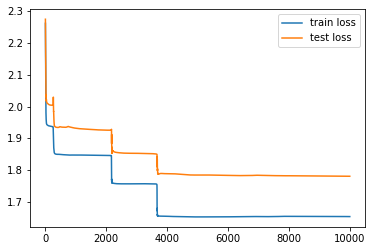

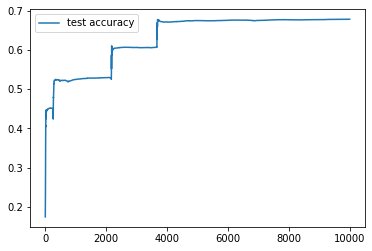

max accuracy: 0.6792


In [13]:
# Fine Tuning Self Supervised Model with Supervised Learning

import copy

# creating duplicate models for finetuning
model_same_head= copy.deepcopy(model)
model_new_head = copy.deepcopy(model)

# replacing the projection head with a randomly initialized head for one of the models
model_new_head.head = Head()

# training models
print('Training results with the original head')
same_head_maxacc= supervised_train(model_same_head, early_stop=True)

print('\n\nTraining results with randomly initialized head')
new_head_maxacc = supervised_train(model_new_head, early_stop=True)

In [ ]:
"""
These results are purely demonstrative; there was no significant hyperparameter optimization which would 
be necessary in production. However, this notebook does support the theoretical utility of self supervision, 
and the importance of careful usage of the projection head.
"""

# https://towardsdatascience.com/self-supervised-learning-using-projection-heads-b77af3911d33